In [3]:
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install torch

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import json
from pathlib import Path


MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

with open("../outputs/fomc_minutes.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

def analyze_sentiment(text):
    result = finbert(text[:512])[0]  
    return result["label"], result["score"]

df[["sentiment_label", "sentiment_score"]] = df["text"].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)
print(df.columns)

df_result = df[["date", "filename", "sentiment_label", "sentiment_score"]]


df_result.to_csv("../outputs/fomc_sentiment_results.csv", index=False, encoding="utf-8")


Device set to use cpu


Index(['filename', 'date', 'text', 'sentiment_label', 'sentiment_score'], dtype='object')


In [5]:
print(df.columns)


Index(['filename', 'date', 'text', 'sentiment_label', 'sentiment_score'], dtype='object')


In [12]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("punkt")
nltk.download("vader_lexicon")

# 1. Задаем ключевые слова
china_keywords = ["china", "chinese", "beijing", "renminbi", "yuan", "chinese economy"]

# 2. Создаем анализатор тональности
sia = SentimentIntensityAnalyzer()

# 3. Ищем предложения про Китай и оцениваем их тональность
china_mentions = []

for i, row in df.iterrows():
    sentences = nltk.sent_tokenize(row["text"])
    for sentence in sentences:
        sentence_lower = sentence.lower()
        if any(kw in sentence_lower for kw in china_keywords):
            sentiment = sia.polarity_scores(sentence)
            china_mentions.append({
                "date": row["date"],
                "filename": row["filename"],
                "sentence": sentence,
                "sentiment_score": sentiment["compound"],
                "sentiment_pos": sentiment["pos"],
                "sentiment_neg": sentiment["neg"],
                "sentiment_neu": sentiment["neu"]
            })

# 4. Сохраняем в DataFrame
china_df = pd.DataFrame(china_mentions)

# 5. Сохраняем результат
china_df.to_csv("../data/china_sentiment.csv", index=False, encoding="utf-8")

# 6. Быстрый просмотр
china_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,date,filename,sentence,sentiment_score,sentiment_pos,sentiment_neg,sentiment_neu
0,2000-02-02,FOMCminutes20000202.txt,Economic growth appeared to have been brisk in...,0.2732,0.114,0.000,0.886
1,2001-06-27,FOMCminutes20010627.txt,"Most of the developing countries, with the not...",-0.5267,0.000,0.145,0.855
2,2001-11-06,FOMCminutes20011106.txt,"Most major emerging-market economies, with the...",-0.4215,0.000,0.085,0.915
3,2001-12-11,FOMCminutes20011211.txt,Economic growth in China seemed to have slowed...,0.3818,0.245,0.000,0.755
4,2002-11-06,FOMCminutes20021106.txt,The pace of recovery in most of emerging Asia ...,0.3400,0.098,0.000,0.902


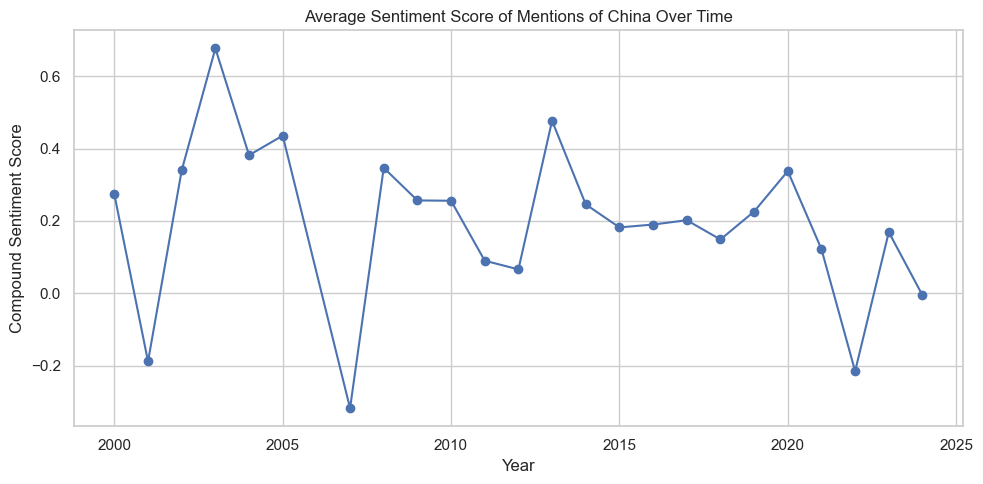

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Убедимся, что колонка 'date' в формате datetime
china_df["date"] = pd.to_datetime(china_df["date"])

# Извлекаем год
china_df["year"] = china_df["date"].dt.year

# Группируем по году и считаем среднее значение compound-тональности
avg_sentiment_by_year = china_df.groupby("year")["sentiment_score"].mean().reset_index()

# Строим график с matplotlib
plt.figure(figsize=(10, 5))
plt.plot(avg_sentiment_by_year["year"], avg_sentiment_by_year["sentiment_score"], marker='o')
plt.title("Average Sentiment Score of Mentions of China Over Time")
plt.xlabel("Year")
plt.ylabel("Compound Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()


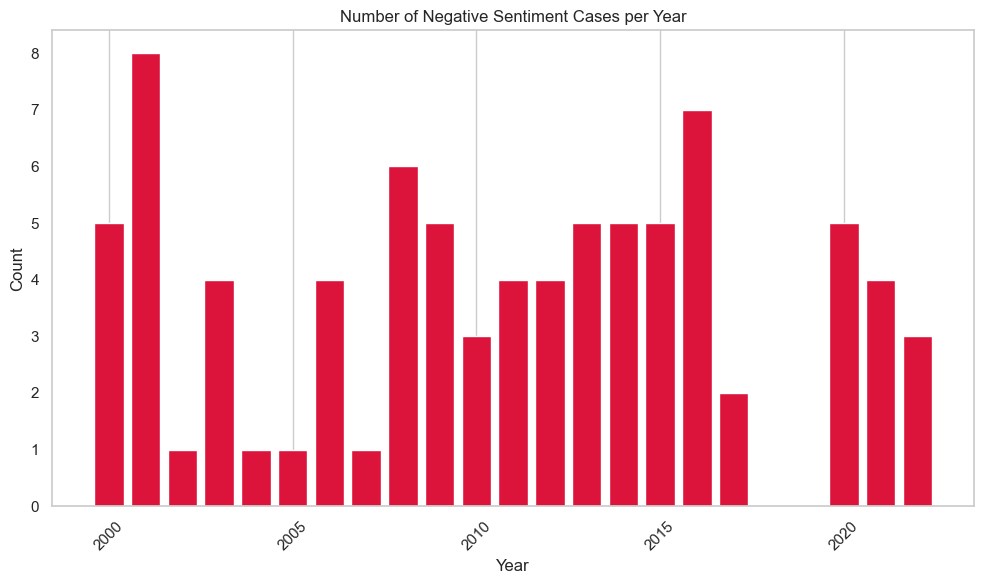

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Чтение CSV-файла
csv_path = "../outputs/fomc_sentiment_results.csv"

with open(csv_path, "r", encoding="utf-8") as file:
    df_sentiment = pd.read_csv(file)

# Преобразуем дату и добавим год
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['year'] = df_sentiment['date'].dt.year

# Оставим только негативные примеры
negative_df = df_sentiment[df_sentiment['sentiment_label'].str.lower() == 'negative']

# Посчитаем количество негативных случаев по годам
neg_counts = negative_df.groupby('year').size()

# Построим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(neg_counts.index, neg_counts.values, color='crimson')
plt.title("Number of Negative Sentiment Cases per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()





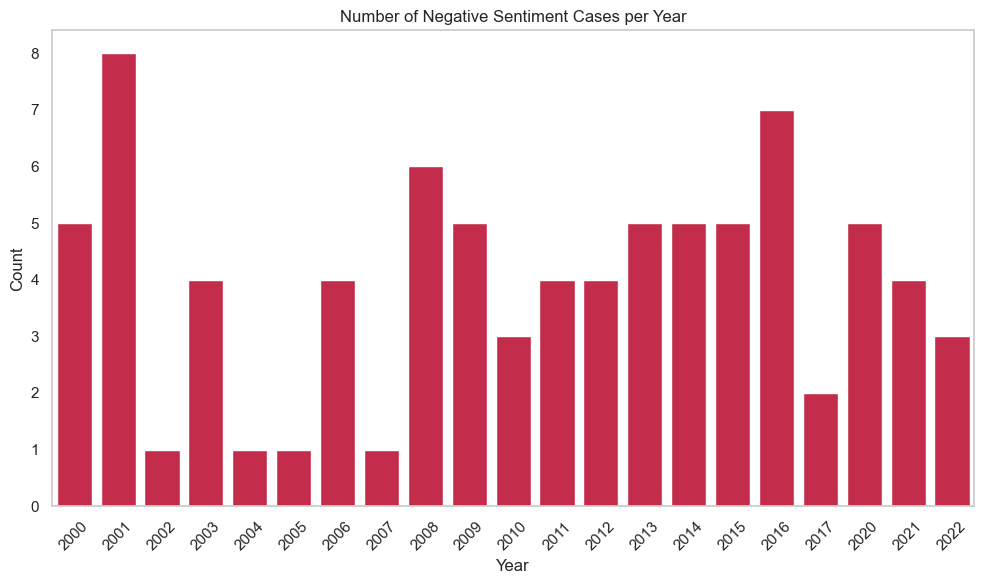

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
csv_path = "../outputs/fomc_sentiment_results.csv"
df_sentiment = pd.read_csv(csv_path, encoding="utf-8")

# Convert date and add year
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['year'] = df_sentiment['date'].dt.year

# Keep only negative examples
negative_df = df_sentiment[df_sentiment['sentiment_label'].str.lower() == 'negative']

# Count negative cases by year
neg_counts = negative_df.groupby('year').size().reset_index(name='count')

# Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=neg_counts, x='year', y='count', color='crimson')
plt.title("Number of Negative Sentiment Cases per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

# Загрузка ресурсов
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Функция для извлечения прилагательных из текста
def extract_adjectives(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha() and w.lower() not in stop_words]
    pos_tags = pos_tag(tokens)
    adjectives = [word for word, tag in pos_tags if tag in ["JJ", "JJR", "JJS"]]
    return adjectives

# Список для хранения строк датасета
rows = []

# Обрабатываем каждый текст
for _, row in df.iterrows():
    filename = row["filename"]
    adjectives = extract_adjectives(row["text"])
    counter = Counter(adjectives)
    top_20 = counter.most_common(20)
    for adj, freq in top_20:
        rows.append({
            "filename": filename,
            "adjective": adj,
            "frequency": freq
        })

# Создаём итоговый DataFrame
adjectives_df = pd.DataFrame(rows)

# Сохраняем в файл
adjectives_df.to_csv("../data/top_adjectives_by_file.csv", index=False)

# Быстрый просмотр
adjectives_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,filename,adjective,frequency
0,FOMCminutes20000202.txt,economic,14
1,FOMCminutes20000202.txt,fourth,11
2,FOMCminutes20000202.txt,recent,10
3,FOMCminutes20000202.txt,high,8
4,FOMCminutes20000202.txt,domestic,8


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


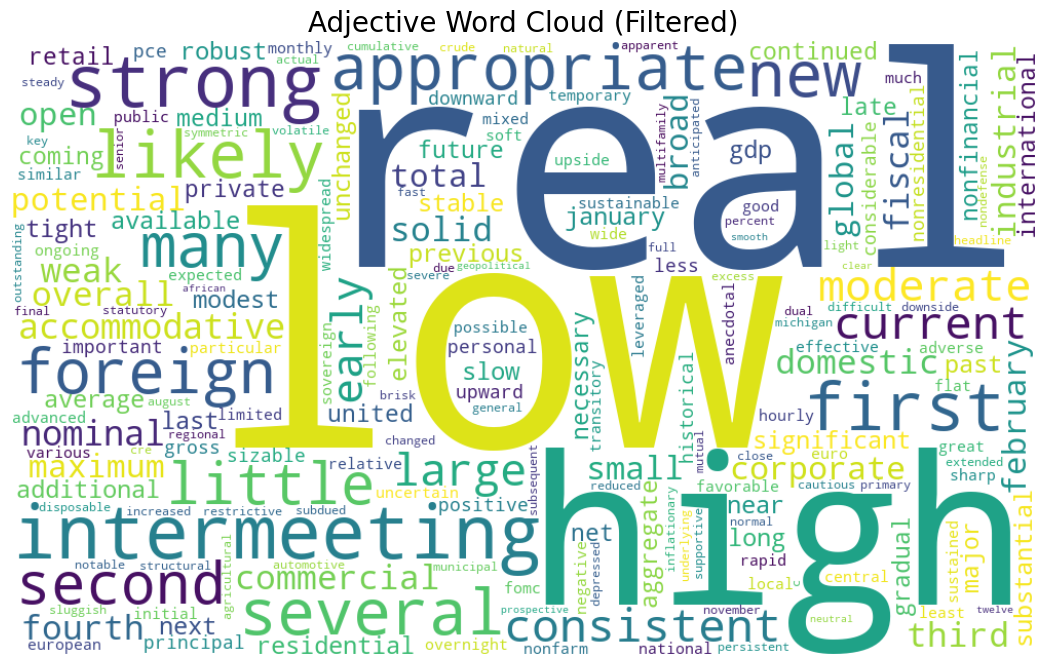

In [9]:
!pip install wordcloud

import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Убедимся, что ресурсы загружены
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

# Загружаем DataFrame (предполагаем, что он уже есть)
# df = pd.read_csv("your_file.csv")  # <- раскомментируй и подставь путь, если нужно

# Настройки
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
remove_adjs = {"federal", "economic", "monetary", "financial", "recent"}

# Сбор всех прилагательных
all_adjectives = []

for text in df["text"]:
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    for word, tag in tagged:
        if tag in ["JJ", "JJR", "JJS"]:  # Все формы прилагательных
            lemma = lemmatizer.lemmatize(word, pos="a")
            if lemma not in stop_words and lemma not in remove_adjs and lemma.isalpha():
                all_adjectives.append(lemma)

# Подсчёт
adj_counter = Counter(all_adjectives)

# Облако слов
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(adj_counter)

# Визуализация
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Adjective Word Cloud (Filtered)", fontsize=20)
plt.show()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\olegv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


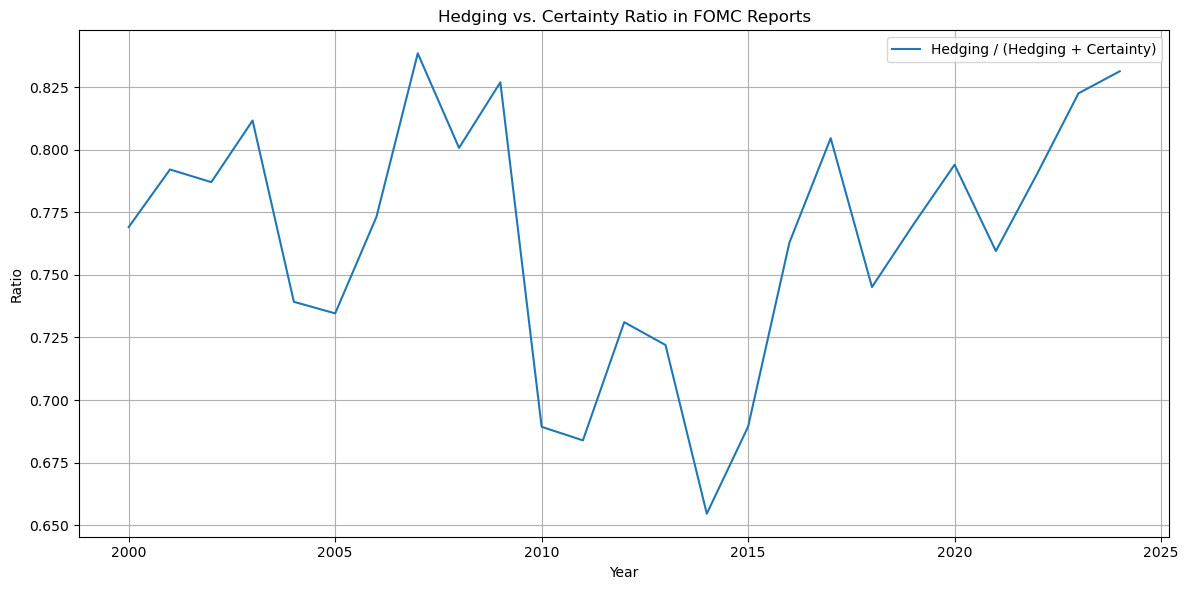

In [11]:
import json
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Загрузка NLTK-ресурсов
nltk.download('punkt')
nltk.download('stopwords')

# Шаг 1. Загрузка данных
with open("../outputs/fomc_minutes.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Шаг 2. Словари
# Шаг 2. Словари
hedging_words = set([
    "may", "might", "could", "possibly", "perhaps", "uncertain", "unlikely", "doubt", "suggest", 
    "possible", "estimate", "assume", "approximate", "project", "expect", "risk", "vulnerable", "concern"
])
certainty_words = set([
    "will", "definitely", "clearly", "undoubtedly", "confident", "assured", 
    "strongly", "expectation", "certain", "firm", "proven", "predictable", "consistent", "confirm"
])


# Обработка текста
stop_words = set(stopwords.words("english"))
punct = set(string.punctuation)

def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [w for w in tokens if w.isalpha() and w not in stop_words and w not in punct]

# Шаг 3. Подсчёт слов по категориям
results = []

for _, row in df.iterrows():
    tokens = preprocess(row["text"])
    counter = Counter(tokens)

    hedging_count = sum(counter[w] for w in hedging_words)
    certainty_count = sum(counter[w] for w in certainty_words)
    total_words = len(tokens)

    hc_total = hedging_count + certainty_count
    ratio = hedging_count / hc_total if hc_total > 0 else 0

    results.append({
        "year": row["year"],
        "hedging": hedging_count,
        "certainty": certainty_count,
        "total_words": total_words,
        "hedging_certainty_ratio": ratio,
    })

result_df = pd.DataFrame(results)

# Шаг 4. Группировка по годам
yearly = result_df.groupby("year")["hedging_certainty_ratio"].mean().reset_index()

# Шаг 5. Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly, x="year", y="hedging_certainty_ratio", label="Hedging / (Hedging + Certainty)")
plt.title("Hedging vs. Certainty Ratio in FOMC Reports")
plt.ylabel("Ratio")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
